# Computational Notebook for Baseline Model

The goal of this notebook is to implement and play with the baseline vanilla model.

First, let's load some dependencies.

In [1]:
# Dependencies
using Pkg 
pkg"activate .."
using LinearAlgebra, Statistics
using Distributions, Plots, StatsPlots, Expectations, Parameters

Next, let's define the baseline model.

In [2]:
Model = @with_kw (λ_bar = 1/2, # market threshold for investing
                    λ = 1/3, # common prior about share of high types
                    R = 1/2, # payoff from investment
                    ω_L = Uniform(0, 1), # low type outside option distribution
                    ω_H = Uniform(0, 1), # high type outside option distribution
                    F_L = x -> cdf(ω_L, x), # these are based on the previous distributions
                    F_H = x -> cdf(ω_H, x),
                    f_L = x -> pdf(ω_L, x),
                    f_H = x -> pdf(ω_H, x))

#3 (generic function with 2 methods)

We can instantiate a model object with these parameters.

In [3]:
baseline = Model();

We can also tweak the parameters a bit.

In [4]:
high_λ = Model(λ = 0.99);
high_λ.λ

0.99

Now, let's write an equilibrium utility routine (assuming an interior solution).

In [5]:
function utility(vals; m = baseline)
    ϕ, p = vals
    @unpack λ_bar, λ, R, ω_L, ω_H, F_L, F_H, f_L, f_H = m 
    # test for constraint satisfaction, return 0 otherwise 
    if F_L(ϕ*R - p)*λ_bar*(1-λ) > F_H(R - p)*λ*(1-λ_bar)
        return 0. 
    end
    # return the actual utility
    return 100*p*(λ*F_H(R - p) + (1-λ)*F_L(ϕ*R - p)) # multiply by 100 for legibility
end

utility (generic function with 1 method)

Note that the above is a complete statement of the problem, independent of any FOCs, etc. We're trying to maximize the utility function above, subject to nonnegativity constraints on price and lying. 

We can try giving it to a nonlinear solver.

## Nonlinear Solver

In [6]:
using BlackBoxOptim, Suppressor

In [25]:
res = @suppress bboptimize(x -> -1*utility(x), SearchRange = (0.0, 1.0), NumDimensions = 2, MaxTime = 20);

In [17]:
best_fitness(res), best_candidate(res)

(-4.166666666666667, [0.75, 0.25])

Here, the first piece is negative utility, and the second piece is the vector $[\phi, p]$

We can try tweaking parameters.

In [9]:
m = Model(λ = 0.75) # up from 0.5
res = @suppress bboptimize(x -> -1*utility(x; m = m), SearchRange = (0.0, 1.0), NumDimensions = 2, MaxTime = 20);
best_fitness(res), best_candidate(res)

(-6.250000000000001, [1.0, 0.25])

In [19]:
m = Model(λ_bar = 0.3) # down from 1/3
res = @suppress bboptimize(x -> -1*utility(x; m = m), SearchRange = (0.0, 1.0), NumDimensions = 2, MaxTime = 30);
best_fitness(res), best_candidate(res)

(-6.250000000000002, [1.0, 0.25])

As expected, increasing the share of high types and decreasing the market confidence threshold both results in increased profits for the credit rater.

In [11]:
m = Model(R = 0.75) # up from 0.5
res = @suppress bboptimize(x -> -1*utility(x; m = m), SearchRange = (0.0, 1.0), NumDimensions = 2, MaxTime = 20);
best_fitness(res), best_candidate(res)

(-9.375, [0.75, 0.375])

Likewise, increasing the market reward does as well (and lets the rater charge a higher price).

We can also try tweaking the distriibutions.

In [20]:
m = Model(ω_H = Uniform(0.25, 1.25)) # from U(0, 1)
res = @suppress bboptimize(x -> -1*utility(x; m = m), SearchRange = (0.0, 1.0), NumDimensions = 2, MaxTime = 20);
best_fitness(res), best_candidate(res)

(-1.0416666666666667, [0.375, 0.125])

Utility here is sharply diminished, probably because high types have less reason to play the market at a higher price.

In [23]:
m = Model(ω_L = Uniform(0.5, 1.5)) # from U(0, 1)
res = @suppress bboptimize(x -> -1*utility(x; m = m), SearchRange = (0.0, 1.0), NumDimensions = 2, MaxTime = 30);
best_fitness(res), best_candidate(res)

(-2.0833333333333335, [0.699809, 0.25])

Here, utility increases, because for any given price $p$, less low types than usual will enter.

## Plots

We can also plot utility over the entire parameter space.

In [28]:
using Plots, LaTeXStrings

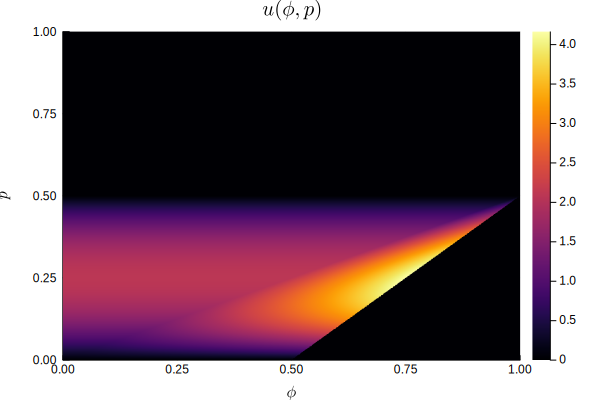

In [32]:
heatmap(0.:0.00125:1.0, 0.:0.00125:1.0, (ϕ, p) -> utility([ϕ, p]), xlabel = L"\phi", ylabel = L"p", title = L"u(\phi, p)")

Note that the optimum at $(0.75, 0.25)$ is right about where the solver predicted.

And in the tweaked cases.

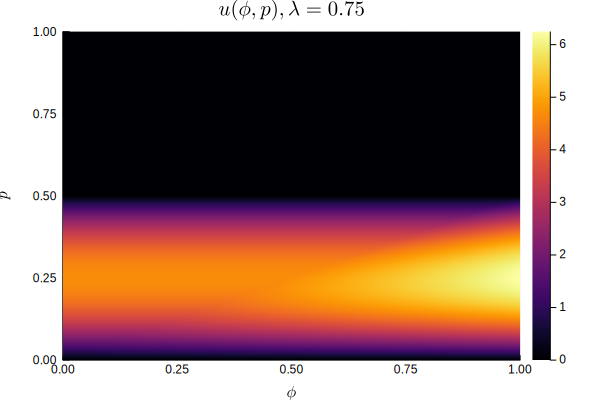

In [33]:
m = Model(λ = 0.75) # up from 0.5
heatmap(0.:0.00125:1.0, 0.:0.00125:1.0, (ϕ, p) -> utility([ϕ, p]; m = m), xlabel = L"\phi", ylabel = L"p", title = L"u(\phi, p), \lambda = 0.75")

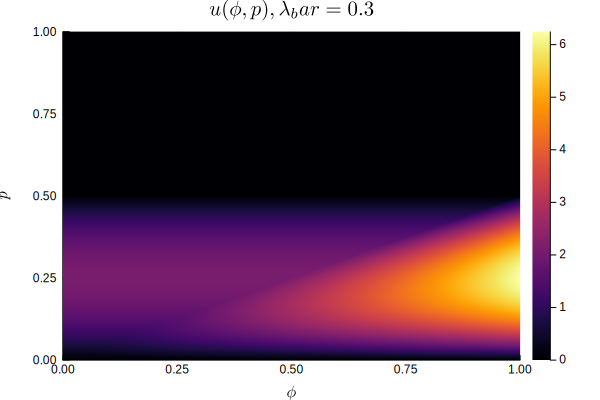

In [34]:
m = Model(λ_bar = 0.3) # up from 0.5
heatmap(0.:0.00125:1.0, 0.:0.00125:1.0, (ϕ, p) -> utility([ϕ, p]; m = m), xlabel = L"\phi", ylabel = L"p", title = L"u(\phi, p), \lambda_bar = 0.3")

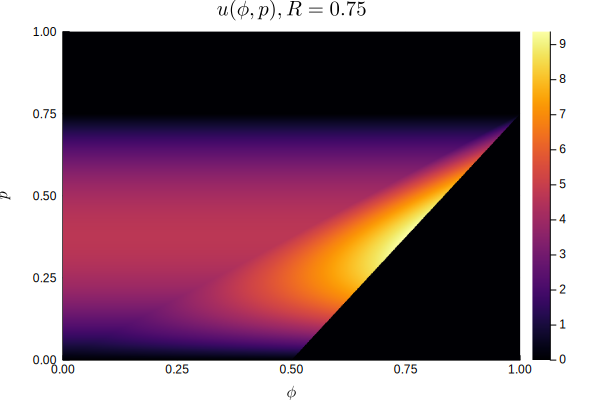

In [35]:
m = Model(R = 0.75) # up from 0.5
heatmap(0.:0.00125:1.0, 0.:0.00125:1.0, (ϕ, p) -> utility([ϕ, p]; m = m), xlabel = L"\phi", ylabel = L"p", title = L"u(\phi, p), R = 0.75")